## Imports & Tested Version 

In [1]:
import sys
print(sys.executable)


/Users/joaomata/AANet_env_clean/bin/python


In [2]:
import sys, torch, scprep
sys.path.append('../')
import warnings; warnings.filterwarnings('ignore')
from AAnet_torch import *
from torch import optim
import torchvision; from torchvision import datasets, transforms
import numpy as np
import matplotlib; import matplotlib.pyplot as plt
from AAnet_torch import models, utils, data, plot


In [4]:
print ('Python', sys.version)
print ('torch', torch.__version__)
print ('torchvision', torchvision.__version__)
print ('scprep', scprep.__version__)
print ('numpy', np.__version__)
print ('matplotlib', matplotlib.__version__)

Python 3.11.1 (v3.11.1:a7a450f84a, Dec  6 2022, 15:24:06) [Clang 13.0.0 (clang-1300.0.29.30)]
torch 2.9.1
torchvision 0.24.1
scprep 1.2.3
numpy 1.26.4
matplotlib 3.10.7


## Load MNIST data

In [5]:
# Load MNIST and normalize for tanh activation [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_all = mnist.data.numpy()
data_all = data_all / 255
data_all = (data_all * 2) - 1 # norm
labels = mnist.train_labels.numpy()

In [6]:
# pick single digit
digit = 4
idx_digit = mnist.train_labels.numpy() == digit
data_digit = data_all[idx_digit,]
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))
print(data_digit.shape)

(5842, 784)


## AAnet

In [7]:
N_ARCHETYPES = 3
data_loader = torch.utils.data.DataLoader(data_digit, batch_size=256, shuffle=True, num_workers=4)

# warm-start model with graph-based extrema for improved results
extrema = torch.Tensor(utils.get_laplacian_extrema(data_digit, n_extrema=N_ARCHETYPES))
extrema = torch.Tensor(data_digit[extrema.numpy().astype(int)])

In [10]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=data_digit.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Run AAnet

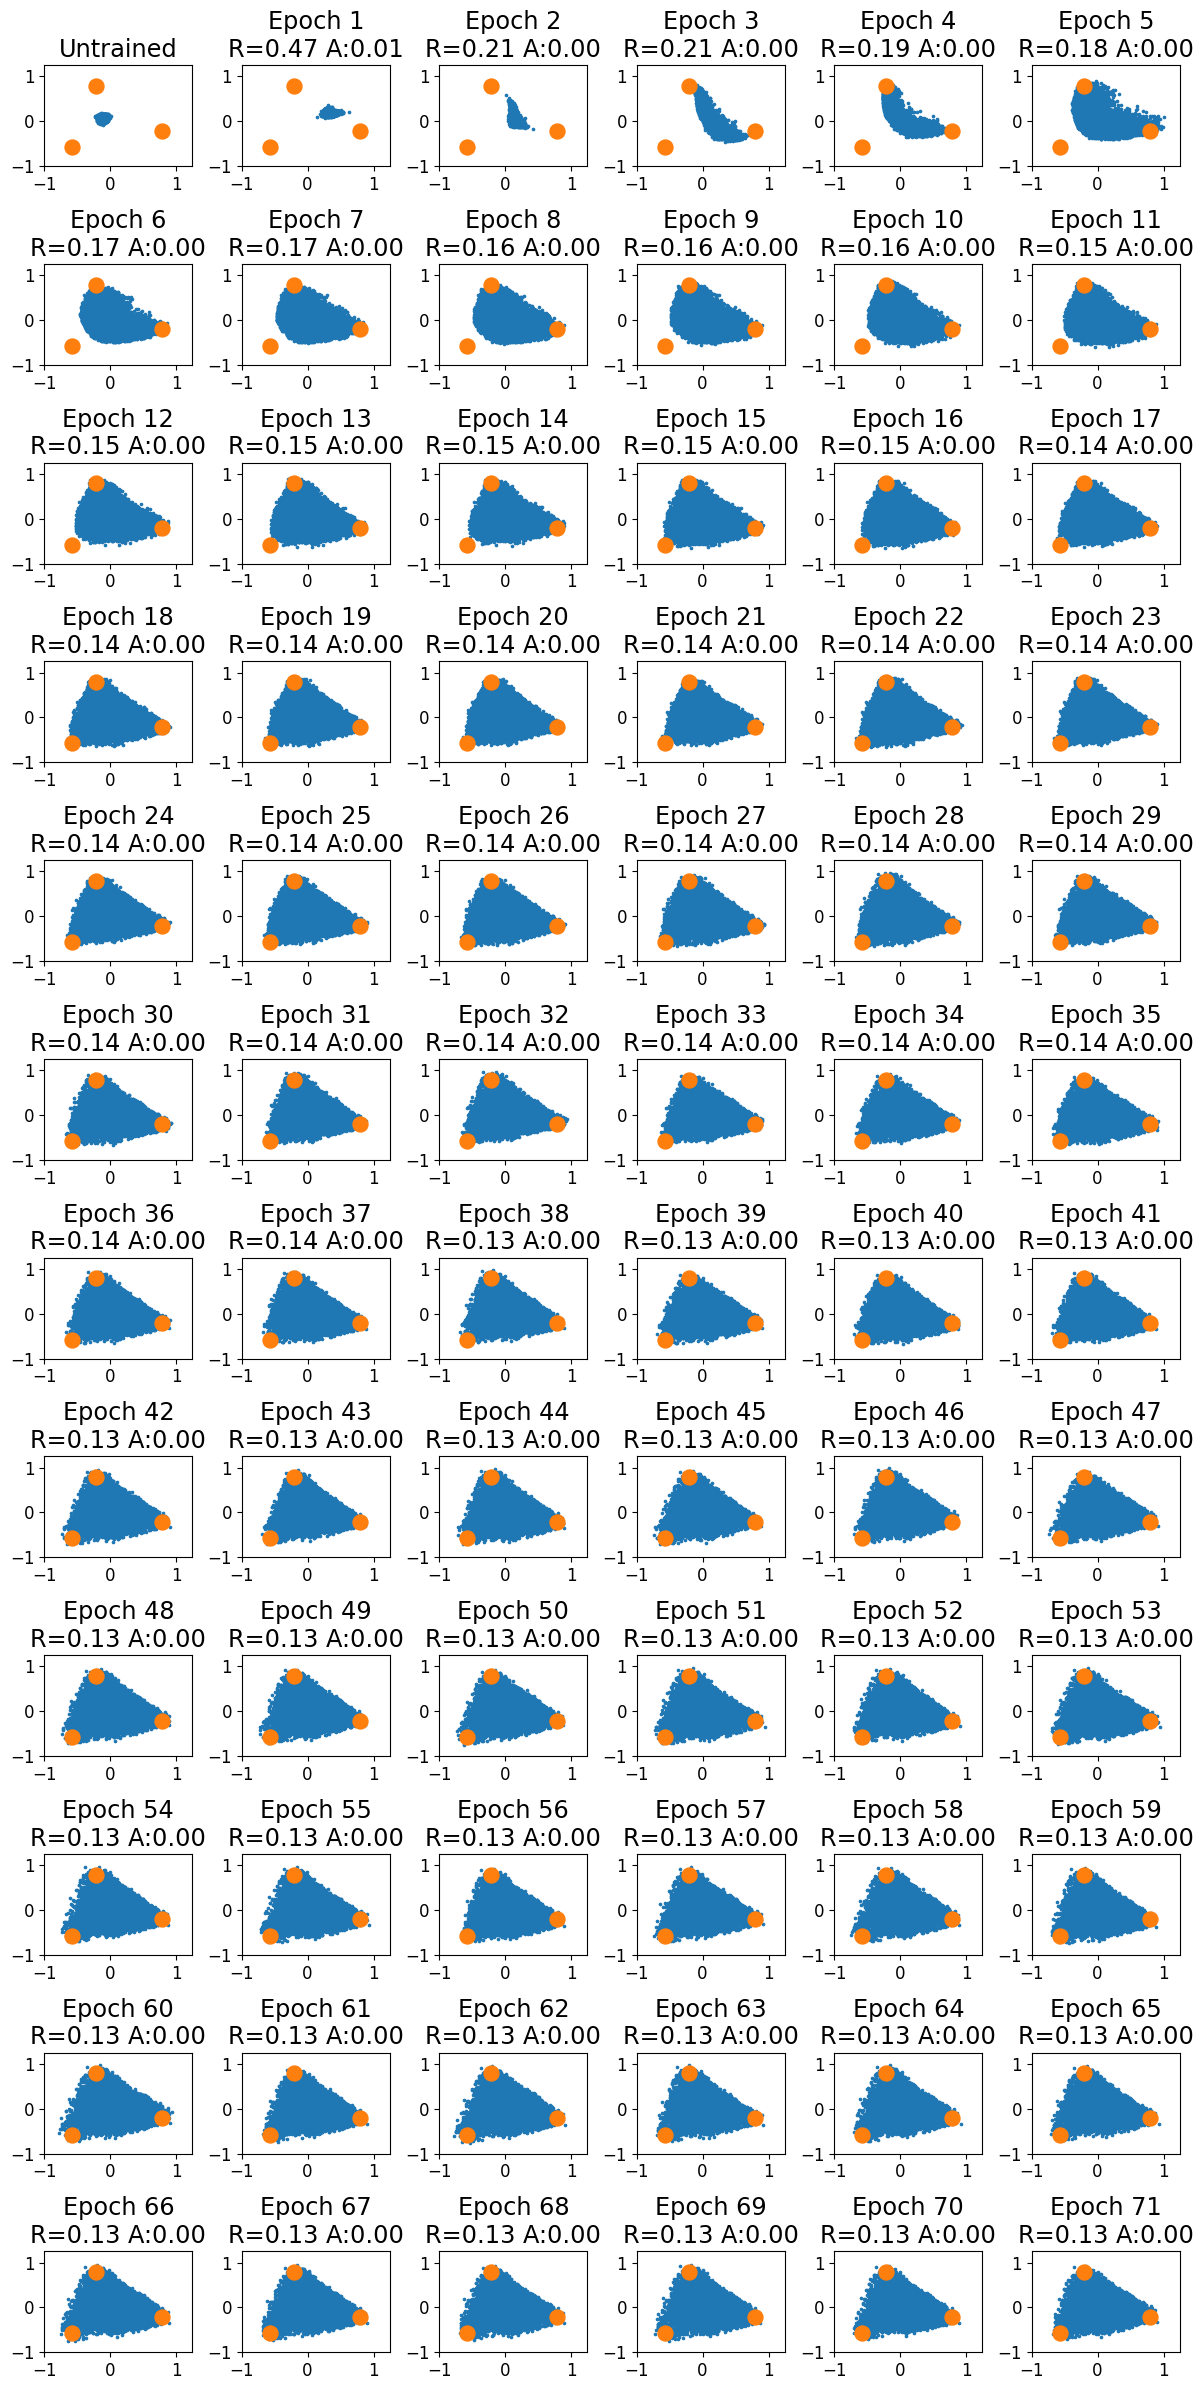

In [11]:
n_row = 12
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        r_loss = a_loss = 0

        title='Untrained'
    else:
        # gamma_extrema parameter weights how informative graph-based extrema are to model
        # higher gamma_extrema = more pushing AAnet to learn the archetypes learned from the graph-based approach
        loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i, gamma_extrema=1.0)
        title='Epoch {}\nR={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)

    archetypal_embedding = model.encode(torch.Tensor(data_digit))

    scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
    scprep.plot.scatter2d(model.get_n_simplex(model.n_archetypes).cpu().numpy(), ax=ax)
    ax.set_xlim(-1, 1.25)
    ax.set_ylim(-1, 1.25)

fig.tight_layout()

### Visualize latent space

In [12]:
archetypal_embedding = model.encode(torch.Tensor(data_digit))
vertices_embedding = model.get_n_simplex(n=3)
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

<Axes: >

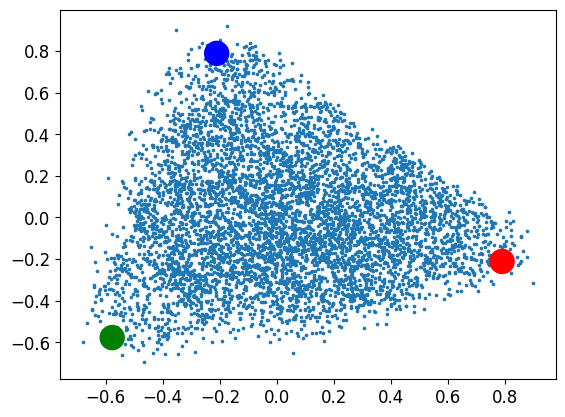

In [13]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(archetypal_embedding.detach().numpy(), ax=ax)
scprep.plot.scatter2d(vertices_embedding.detach().numpy(), ax=ax, c=['red', 'blue', 'green'], s=300)

### Visualize average of 20 images nearest each archetype

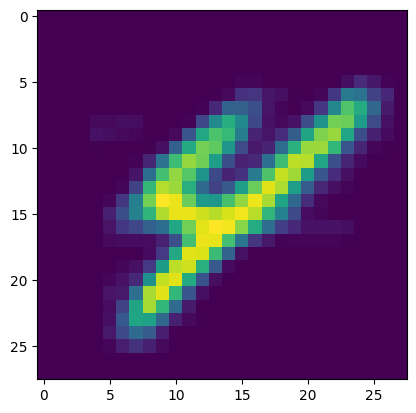

In [14]:
images_close_to_red_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 0])[::-1][:20]
images_close_to_red_archetype = data_digit[images_close_to_red_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_red_archetype.mean(axis=0))

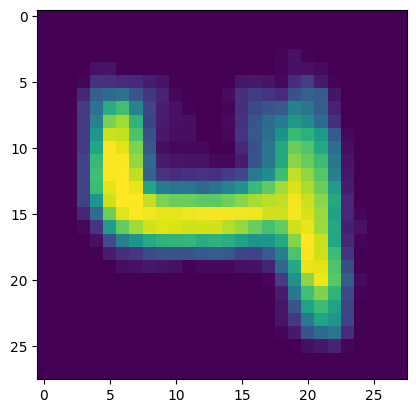

In [15]:
images_close_to_blue_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 1])[::-1][:20]
images_close_to_blue_archetype = data_digit[images_close_to_blue_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_blue_archetype.mean(axis=0))

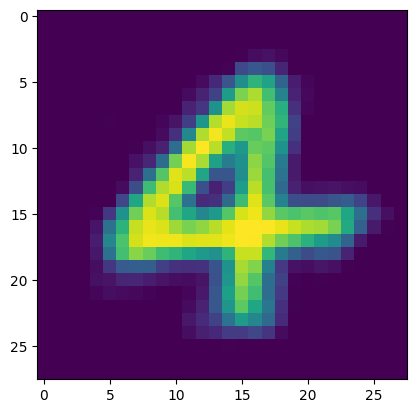

In [16]:
images_close_to_green_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 2])[::-1][:20]
images_close_to_green_archetype = data_digit[images_close_to_green_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_green_archetype.mean(axis=0))

In [ ]:
torch.save(model.state_dict(), f'results/AAnet_MNIST_digit{digit}_model.pth')
np.savez(f'results/AAnet_MNIST_digit{digit}_results.npz', data_ats=data_digit, pc_ats=archetypal_embedding.detach().numpy(), latent_coords=barycentric_archetypal_embedding)

---

## Loading the results (don't rerun the code above)

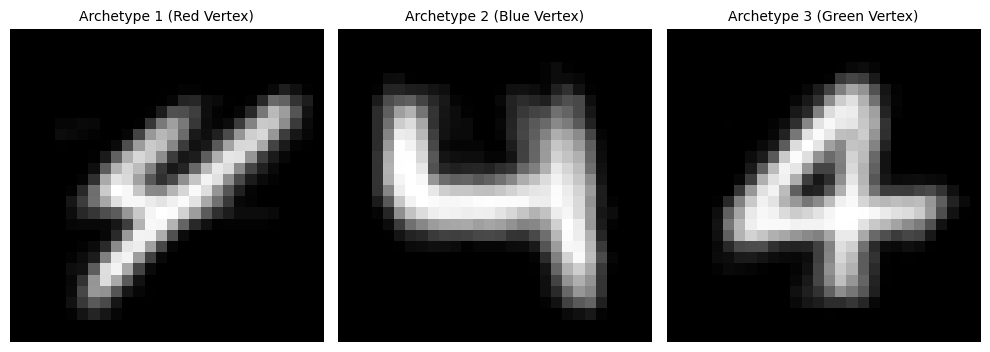

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the filename based on previous context
filename = 'results/AAnet_MNIST_digit4_results.npz'

# 1. Load the saved data archive
saved_data = np.load(filename)

# 2. Extract the original data and barycentric coordinates
data_ats = saved_data['data_ats']
barycentric_archetypal_embedding = saved_data['latent_coords']

# Constants for visualization
N_ARCHETYPES = 3
N_PROTOTYPES = 20
colors = ['Red', 'Blue', 'Green']

# 3. Create a figure with 3 subplots
fig, axes = plt.subplots(1, N_ARCHETYPES, figsize=(10, 4))

for i in range(N_ARCHETYPES):
    ax = axes[i]
    
    # 5. Find the indices of the N_PROTOTYPES images closest to this archetype
    # np.argsort sorts in ascending order, so [::-1] reverses it, and [:N_PROTOTYPES] takes the top N.
    images_close_to_archetype_idx = np.argsort(
        barycentric_archetypal_embedding[:, i]
    )[::-1][:N_PROTOTYPES]

    # 6. Get the raw image data for these closest points and reshape for averaging
    images_close_to_archetype = data_ats[images_close_to_archetype_idx].reshape(N_PROTOTYPES, 28, 28)

    # Calculate the average image (the prototype)
    prototype_image = images_close_to_archetype.mean(axis=0)

    # Plot the prototype
    ax.imshow(prototype_image, cmap='gray')
    ax.set_title(f'Archetype {i+1} ({colors[i]} Vertex)', fontsize=10)
    ax.axis('off')

# 7. Save the figure
fig.tight_layout()
plt.savefig('results/all_archetype_prototypes_MNIST.png')

**Goal: Extract S directly and reconstruct C (Prototypes) from the saved results. Note: AAnet data is often scaled to [-1, 1]. We rescale it to [0, 1] to match Linear AA.**

In [3]:
import numpy as np
import torch

def get_aanet_matrices(npz_path, n_archetypes=3, n_prototypes=20):
    """
    Extracts S, C, and X from AAnet results file.
    """
    # 1. Load Results
    saved_data = np.load(npz_path)
    
    # 2. Extract Data (X) and Coefficients (S)
    # AAnet X is usually (N, Features)
    X_aanet = saved_data['data_ats'] 
    
    # Rescale X from [-1, 1] to [0, 1] for fair comparison with Linear AA
    X_aanet = (X_aanet + 1) / 2
    
    # AAnet S is usually (N, k), we need (k, N)
    S_aanet = saved_data['latent_coords'].T 
    
    # 3. Reconstruct Archetypes (C) using the "Prototype" method
    # (Average of the top N closest samples, just like in the notebook viz)
    n_features = X_aanet.shape[1]
    C_aanet = np.zeros((n_features, n_archetypes))
    
    for i in range(n_archetypes):
        # Get coefficients for this archetype across all samples
        # Sort samples by their contribution to this archetype
        top_indices = np.argsort(S_aanet[i, :])[::-1][:n_prototypes]
        
        # Average the top N samples to get the archetype
        C_aanet[:, i] = X_aanet[top_indices].mean(axis=0)
        
    return S_aanet, C_aanet, X_aanet

# Usage
S1, C1, X1 = get_aanet_matrices('results/AAnet_MNIST_digit4_results.npz')